# Predict shapes

In [33]:
import sys
sys.path.insert(0, "..")
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch

from sklearn.metrics import confusion_matrix
from PIL import Image

In [34]:
from dataloader import mask2rgb
from model import UNet, make_dataloaders, compute_IoU

In [35]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = ("cuda" if torch.cuda.is_available() else "cpu" )

In [36]:
MODEL_PATH = '..\checkpoints\path_to_your_model\CP.pth'
PATH_PARAMETERS = os.path.join('../runs', os.path.basename(os.path.dirname(MODEL_PATH)), 'config.json')

with open(PATH_PARAMETERS) as f:
    config_data = json.load(f)

model_params = config_data['models_settings']

In [ ]:
config_data['data_preprocessing']['use_augmentation'] = False
config_data['data_preprocessing']['use_patches'] = False

dir_data = f'../data/{config_data["training_parameters"]["data_folder"]}'
params = {'batch_size': 1, 'shuffle': False}

test_loader, _ =  make_dataloaders(dir_data, 0, config_data, params)


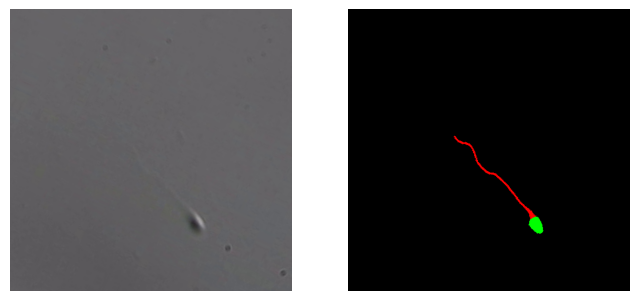

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,10))

for i, sample_batch in enumerate(test_loader):
        imgs = sample_batch['image']
        true_masks = sample_batch['mask']
        img  = np.transpose(imgs[0].squeeze().cpu().detach().numpy(), (1,2,0))
        img = img[:,:,:3]
        mask_true = true_masks[0].cpu().detach().numpy()

        ax[0].imshow(img)
        ax[0].axis('off')
        ax[1].imshow(mask2rgb(mask_true))
        ax[1].axis('off')

In [ ]:
n_channels= model_params['n_channels']
n_classes= model_params['n_classes']
net = UNet(n_channels=n_channels, n_classes=n_classes)
net.to(device)

net.load_state_dict(torch.load(MODEL_PATH ,map_location=torch.device('cpu')))
print('Model loaded from {}'.format(MODEL_PATH))
net.eval()

In [ ]:
n_classes = model_params['n_classes']
labels = np.arange(n_classes)
cm = np.zeros((n_classes,n_classes))
fig, ax = plt.subplots(1,3,figsize=(20,20))

for i, sample_batch in enumerate(test_loader):

        imgs = sample_batch['image']
        true_masks = sample_batch['mask']

        imgs = imgs.to(device)
        true_masks = true_masks.to(device)

        outputs = net(imgs)

        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        
        img  = np.transpose(imgs[0].squeeze().cpu().detach().numpy(), (1,2,0))
        img = img[:,:,:3]
        mask_true = true_masks[0].cpu().detach().numpy()

        mask_pred = preds[0].cpu().detach().numpy()
        
        ax[0].imshow(img)
        ax[0].set_title('original')
        ax[0].axis('off')
        ax[1].imshow(mask2rgb(mask_true))
        ax[1].set_title('ground truth')
        ax[1].axis('off')
        ax[2].imshow(mask2rgb(mask_pred))
        ax[2].set_title('prediction')
        ax[2].axis('off')

        for j in range(len(true_masks)): 
                true = true_masks[j].cpu().detach().numpy().flatten()
                pred = preds[j].cpu().detach().numpy().flatten()
                cm += confusion_matrix(true, pred, labels=labels)
        
class_iou, mean_iou = compute_IoU(cm)
print('Class IoU:', ' '.join(f'{x:.3f}' for x in class_iou), f'  |  Mean IoU: {mean_iou:.3f}')
